FaST-LMM Manual
=====
Factored Spectrally Transformed Linear Mixed Models
========

#####Version 0.2.15
Microsoft Research, July 15, 2015

### Introduction

FaST-LMM, which stands for Factored Spectrally Transformed Linear Mixed Models, is a program for performing both single-SNP and SNP-set genome-wide association studies (GWAS) on extremely large data sets.  This release contains the improvements described in Widmer _et al._, _Scientific Reports_ 2014, and tests for epistasis.

For help with the software, please contact [fastlmm@microsoft.com](fastlmm@microsoft.com).

### Citing FaST-LMM

If you use FaST-LMM in any published work, please cite the relevant manuscript(s) describing it.







 

### Data preparation

This version of FaST-LMM is designed for use with randomly ascertained data with Gaussian residuals.  If you have case-control data with substantial ascertainment bias, you should first transform your phenotype(s) using LEAP (Weissbrod _et al._, _arXiv_ 2014), which is available at https://github.com/omerwe/LEAP.  If you are analyzing continuous phenotypes with non-Gaussian residuals, you should first transform your phenotype(s) using Warped-LMM (Fusi et al., _Nature Commun_ 2014), available at https://github.com/MicrosoftGenomics/WarpedLMM.

FaST-LMM uses four input files containing (1) the SNP data to be tested, (2) the SNP data used to determine the genetic similarity matrix (GSM) between individuals (which can be different from 1), (3) the phenotype data, and (4, optionally) a set of covariates.

SNP files can be in PLINK format (ped/map, tped/tfam, bed/bim/fam, or fam/dat/map).  For the most speed, use the binary format in SNP major order.  See the PLINK manual http://pngu.mgh.harvard.edu/~purcell/plink/ (Purcell et al., _Am J Hum Genet_ 2007) for further details.  FaST-LMM also supports Hdf5 file format http://www.hdfgroup.org/HDF5/whatishdf5.html.  See https://github.com/MicrosoftGenomics/PySnpTools for more details.  Note that each SNP is standardized to have mean zero and standard deviation one across all individuals before processing.  Missing values are mean imputed.

The required file containing the phenotype uses the PLINK alternate phenotype format with no header.  The covariate file also uses this format (with additional columns for multiple covariates).


###Notebook preparation and general use

To prepare this notebook to run analyses, please run the following script.  

In [1]:
# set some ipython notebook properties
%matplotlib inline

# set degree of verbosity (adapt to INFO for more verbose output)
import logging
logging.basicConfig(level=logging.WARNING)

# set figure sizes
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# set display width for pandas data frames
import pandas as pd
pd.set_option('display.width', 1000)

If you would like to run any of the code below from the command line, first copy it into a file (_e.g._, `test.py`), and then run it by typing `python text.py` at the command line.

If you would like to see all the options for a function just type `? <function_name>` to an ipython prompt.

### Single-SNP association testing



####Traditional analysis: LMM(all)

First, let's run a standard LMM analysis in which the GSM uses (almost) all available SNPs.  The model for this analysis is called LMM(all) in  Widmer _et al._, _Scientific Reports_ 2014.  We'll apply this model to the synthetic data in `tests\datasets\synth`.  The data has 500 samples with 5000 SNPs, and was generated from a Balding-Nichols model with FST=0.05.

When using a linear mixed model for association analysis, it is important to avoid proximal contamination (Lippert _et al._, _Nat Meth_ 2011). To understand proximal contamination, first note that a LMM with no fixed effects, using a realized relationship matrix for the GSM (as FaST-LMM does), is mathematically equivalent to linear regression of the SNPs on the phenotype, with weights integrated over independent Normal distributions having the same variance (_e.g._, Hayes _et al._, _Genet Res_ 2009).  That is, a LMM using a given set of SNPs for the GSM is equivalent to a form of linear regression using those SNPs as covariates to correct for confounding.  This equivalence implies that, when testing a given SNP, that SNP (and SNPs physically close to it) should be excluded from the computation of the GSM.  If not, when testing a particular SNP, we would also be using that same SNP as a covariate, making the log likelihood of the null model higher than it should be, thus leading to deflation of the test statistic and loss of power.

Excluding the SNP you are testing and those SNPs in close proximity to it from the GSM in a naïve way is extremely computationally expensive.  A computationally efficient approach for performing the exclusion is to use a GSM computed from all but chromosome $i$ when testing SNPs on chromosome $i$ (Lippert _et al._, _Nat Meth_ 2011).  We call this approach leave out one chromosome (LOOC).  The analysis here does this.


C:\Anaconda\lib\site-packages\matplotlib\__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


                    SNP  Chr  GenDist  ChrPos        PValue  SnpWeight  SnpWeightSE  SnpFractVarExpl    Nullh2
0   snp495_m0_.01m1_.04    5     4052    4052  2.990684e-23   0.418653     0.040052         0.424521  0.451117
1   snp1422_m0_.49m1_.5    3     2392    2392  8.251921e-23  -0.416495     0.040300         0.420587  0.279710
2  snp1200_m0_.37m1_.36    3     2650    2650  3.048007e-14   0.328870     0.042021         0.331240  0.279710
3   snp433_m0_.14m1_.11    3     2003    2003  9.202499e-10  -0.268289     0.042973         0.269670  0.279710
4   snp2832_m0_.46m1_.1    4     3274    3274  7.069762e-04   0.170421     0.050003         0.151124  0.542046
5  snp1413_m0_.04m1_.03    3     2013    2013  8.161238e-04  -0.148719     0.044157         0.149377  0.279710
6   snp2804_m0_.16m1_.3    3     2214    2214  1.239806e-03   0.150705     0.046396         0.144180  0.279710
7   snp751_m0_.04m1_.25    1      117     117  1.527432e-03  -0.152430     0.047827         0.141523  0.614963
8

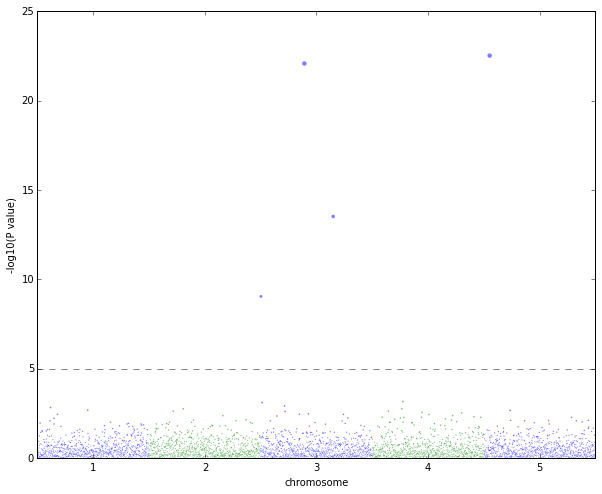

lambda=1.0078


(<matplotlib.figure.Figure at 0x19d4b4e0>,
 array([  4.00000000e+00,   3.52287875e+00,   3.30103000e+00, ...,
          2.17201546e-04,   1.30307892e-04,   4.34316198e-05]),
 array([  2.00000000e+01,   2.00000000e+01,   1.35159840e+01, ...,
          2.70503422e-04,   1.43911779e-04,   4.22528155e-05]))

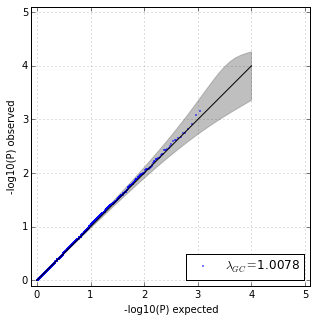

In [2]:
# import the algorithm
from fastlmm.association import single_snp_leave_out_one_chrom

# set up data
##############################
bed_fn = "../../tests/datasets/synth/all"
pheno_fn = "../../tests/datasets/synth/pheno_10_causals.txt"
cov_fn = "../../tests/datasets/synth/cov.txt"

# run gwas
###################################################################
results_df = single_snp_leave_out_one_chrom(bed_fn,  pheno_fn, covar=cov_fn)

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
print results_df.head(n=10)

# manhattan plot
import pylab
import fastlmm.util.util as flutil
flutil.manhattan_plot(results_df.as_matrix(["Chr", "ChrPos", "PValue"]),pvalue_line=1e-5,xaxis_unit_bp=False)
pylab.show()

# qq plot
from fastlmm.util.stats import plotp
plotp.qqplot(results_df["PValue"].values, xlim=[0,5], ylim=[0,5])

#### Improving power: LMM(all+selecct)

In Widmer _et al._, _Scientific Reports_ 2014, we have shown that power can be increased while still maintaining control of type I error by using two GSMs: one based on all SNPs (`G0`) and one based on selected SNPs that are highly correlated with the phenotype (`G1`).  The model is called LMM(select + all).  This approach has greater computational demands (we recommend using a cluster computer when analyzing large data sets). Here is an example of how to apply this model to the synthetic data.

loadPhen is using default missing value of '-9'.
loadPhen is using default missing value of '-9'.
running feature selection conditioned on background kernel
[1, 2, 5, 11, 25, 57, 128]


c:\Source\carlk\fastlmm2\fastlmm\inference\lmm.py:581: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.G!=None:
c:\Source\carlk\fastlmm2\fastlmm\inference\lmm.py:746: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if Kstar_star == None:


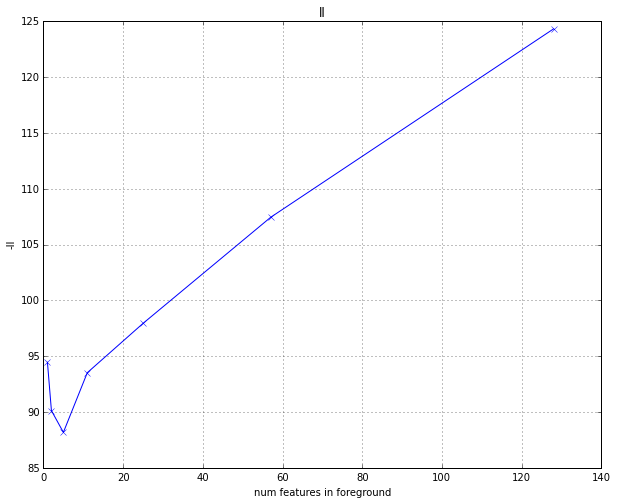

best_k: 5
best_mix: 0.673287196123
best_delta: 0.789314804053
[2392 2650 2003 2214 2013]

results:
########################################
                    SNP  Chr  GenDist  ChrPos        PValue  SnpWeight  SnpWeightSE  SnpFractVarExpl    Nullh2
0   snp495_m0_.01m1_.04    5     4052    4052  1.290421e-33   0.397569     0.030500         0.504379  0.541504
1  snp3970_m0_.53m1_.17    5     4307    4307  4.278276e-04  -0.143173     0.040374         0.156940  0.541504
2   snp3853_m0_.1m1_.04    5     4177    4177  1.442585e-03   0.112940     0.035250         0.142115  0.541504
3   snp2743_m0_.03m1_.1    5     4046    4046  2.515786e-03  -0.107594     0.035429         0.134844  0.541504
4   snp228_m0_.03m1_.27    5     4188    4188  4.641175e-03   0.111030     0.039042         0.126413  0.541504


In [3]:
# example script for two kernel feature selection
# this takes a couple of minutes to run
import numpy as np
import pysnptools.util
from pysnptools.snpreader import Bed

from fastlmm.feature_selection.feature_selection_two_kernel import FeatureSelectionInSample
from pysnptools.util.pheno import loadOnePhen,loadPhen
from fastlmm.association import single_snp

# define file names
bed_fn = "../../tests/datasets/synth/all"
pheno_fn = "../../tests/datasets/synth/pheno_10_causals.txt"
cov_fn = "../../tests/datasets/synth/cov.txt"

# load data
###################################################################
snp_reader = Bed(bed_fn)
pheno = loadOnePhen(pheno_fn)
cov = loadPhen(cov_fn)

# intersect sample ids
snp_reader, pheno, cov = pysnptools.util.intersect_apply([snp_reader, pheno, cov])

# read in snps

# partition snps on chr5 vs rest
test_chr = 5
G0 = snp_reader[:,snp_reader.pos[:,0] != test_chr].read(order='C').standardize()
test_snps = snp_reader[:,snp_reader.pos[:,0] == test_chr].read(order='C').standardize()


y = pheno['vals'][:,0]
y -= y.mean()
y /= y.std()

# load covariates
X_cov = cov['vals']
X_cov.flags.writeable = False

# invoke feature selection to learn which SNPs to use to build G1
print "running feature selection conditioned on background kernel"
# partition data into the first 50 SNPs on chr1 and all but chr1

select = FeatureSelectionInSample(max_log_k=7, n_folds=7, order_by_lmm=True, measure="ll", random_state=42)
best_k, feat_idx, best_mix, best_delta = select.run_select(G0.val, G0.val, y, cov=X_cov)    

# plot out of sample error
select.plot_results(measure="ll")
# select.plot_results(measure="mse")

# print results
print "best_k:", best_k
print "best_mix:", best_mix
print "best_delta:", best_delta


###############################
# use selected SNPs to build G1
print feat_idx
G1 = G0[:,feat_idx]

results_df = single_snp(test_snps, pheno, G0=G0, G1=G1, mixing=best_mix, h2=None)

print 
print "results:"
print "#"*40
print results_df.head()

Aside: In some applications, you may want to use two kernels constructed from two pre-specified sets of SNPs (i.e., with no feature selection). Here we show how to do that and how to simultaneously find h2 and the mixing weight between the kernels.

In [4]:
# example script for two kernel without feature selection
import numpy as np
import pysnptools.util
from pysnptools.snpreader import Bed

from pysnptools.util.pheno import loadOnePhen,loadPhen
from fastlmm.association import single_snp

# define file names
bed_fn = "../../tests/datasets/synth/all"
pheno_fn = "../../tests/datasets/synth/pheno_10_causals.txt"
cov_fn = "../../tests/datasets/synth/cov.txt"

# load data
###################################################################
snp_reader = Bed(bed_fn)
pheno = loadOnePhen(pheno_fn)
cov = loadPhen(cov_fn)

# partition snps on chr5 vs chr6 vs rest
test_chr = 5
G1_chr = 6

G0 = snp_reader[:,(snp_reader.pos[:,0] != test_chr) & (snp_reader.pos[:,0] != G1_chr)]
G1 = snp_reader[:,snp_reader.pos[:,0] == G1_chr]
test_snps = snp_reader[:,snp_reader.pos[:,0] == test_chr]

results_df = single_snp(test_snps, pheno, G0=G0, G1=G1, mixing=None, h2=None)

print 
print "results:"
print "#"*40
print results_df.head()

loadPhen is using default missing value of '-9'.
loadPhen is using default missing value of '-9'.

results:
########################################
                    SNP  Chr  GenDist  ChrPos        PValue  SnpWeight  SnpWeightSE  SnpFractVarExpl    Nullh2
0   snp495_m0_.01m1_.04    5     4052    4052  2.792114e-23   0.418228     0.039981         0.424436  0.451714
1   snp726_m0_.28m1_.31    5     4236    4236  2.181065e-03  -0.133413     0.043309         0.136744  0.451714
2  snp4608_m0_.35m1_.39    5     4785    4785  5.466632e-03  -0.122490     0.043897         0.124075  0.451714
3  snp2615_m0_.49m1_.25    5     4239    4239  7.858790e-03   0.124029     0.046472         0.118750  0.451714
4   snp2619_m0_.08m1_.1    5     4365    4365  8.284254e-03   0.116484     0.043942         0.117960  0.451714


#### Improving speed and memory use when there is little family strucutre: LMM(select)+PCs

In the same publication, we have shown that a simpler, more computationally efficient model can be used when the data is  confounded only by population structure and not by family structure or cryptic relatedness.  Under these circumstances, we have found that a model with a single GSM based on selected SNPs in combination with principle components as fixed-effect covariates yields good control of type I error and power.  

This model, called LMM(select)+PCs, should be used with caution.  Even if you explicitly remove closely related individuals from your data, cryptic relatedness may remain.

To use this model, first identify the principle components to be used with the PCgeno algorithm as described in Widmer _et al._, _Scientific Reports_ 2014.

In [5]:
from pysnptools.snpreader import Bed
from fastlmm.util import compute_auto_pcs

# define file names
bed_fn = "../../tests/datasets/synth/all"
cov_fn = "pcs_cov.txt"

# run PCgeno
#TODO: rename to auto_pcs
result = compute_auto_pcs(bed_fn, output_file_name=cov_fn)

print "selected number of PCs:", result["vals"].shape[1]

selected number of PCs: 1


Now you can call FaST-LMM with feature selection and with these PCs as covariates. Below, we show how to do this with the C++ version of FaST-LMM. Soon, this functionality will be available in the python version.

In [6]:
# import algorithms
from fastlmm.util.run_fastlmmc import runFASTLMM, runLMMSELECT

# set some file paths for fastlmmc
phen_fn = "../../tests/datasets/synth/pheno_10_causals.txt"
out_dir = "."
out_fn = "out.csv"
fastlmm_path = "../../external/fastlmmc"

# consists of two fastlmmc calls, one that does feature selection and one that runs GWAS
output = runLMMSELECT(bed_fn, phen_fn, out_dir, out_fn, bfileSim=bed_fn, fastlmm_path=fastlmm_path)


          Expecting: MKL v11.00.04 - Build: 20130517
              Found: MKL v11.00.01 - Build: 20121016



FastLmmC v2.06.20131029 - Factored Spectrally Transformed Linear Mixed Models [Release]
  Copyright Microsoft Corporation -- Licensed Only for Non-Commercial use.
  Compiled Oct 29 2013 at 20:32:57 by ESCIENCE4 for Windows
  using MKL v11.00.01 - Build: 20121016

 ++    Start Processing CommandLine:
 --      End Processing CommandLine:

 ++            Start DoAutoSelect():
  ++        Start Loading Test Data:
   ++      Processing PLINK fileset: [../../tests/datasets/synth/all]
   ReadBinaryFiles4()* elapsed time:  26.679 ms
     Number of Individuals Selected:     500
               Number of Phenotypes:       1
                Number of SNPs Read:    5000
                Number of SNPs Used:    5000
   --  End Processing PLINK fileset: [../../tests/datasets/synth/all]
  ++  Start Preprocessing Test Data:

  ++            Start Fold Creation:
 Select SNPs using cross validatio

#### Epistasis

You can test for epistatic interactions between pairs of SNPs as well.  Here is an example analysis applied to the same synthetic data.  Note that this version of the code uses a likelihood ratio test based on maximum-likelihood estimates.  A REML-based version is in the works.

loadPhen is using default missing value of '-9'.
loadPhen is using default missing value of '-9'.
                   SNP0  Chr0  GenDist0  ChrPos0                  SNP1  Chr1  GenDist1  ChrPos1    PValue  NullLogLike  AltLogLike
0  snp1754_m0_.19m1_.42     1        38       38  snp2376_m0_.38m1_.49     1        20       20  0.000451  -700.878718 -694.724583
1   snp625_m0_.03m1_.07     1         0        0  snp3000_m0_.28m1_.34     1         5        5  0.001306  -700.387891 -695.220652
2   snp250_m0_.23m1_.19     1        15       15  snp2377_m0_.06m1_.02     1        30       30  0.002279  -698.768488 -694.113511
3   snp376_m0_.17m1_.17     1         9        9   snp625_m0_.03m1_.07     1         0        0  0.002287  -700.206861 -695.555229
4   snp125_m0_.64m1_.41     1        21       21  snp1754_m0_.19m1_.42     1        38       38  0.002404  -700.873862 -696.267594
5  snp2878_m0_.82m1_.58     1        42       42  snp1878_m0_.58m1_.36     1        48       48  0.002568  -698.5795

(<matplotlib.figure.Figure at 0x21352710>,
 array([  3.38916608e+00,   2.91204483e+00,   2.69019608e+00, ...,
          8.87220905e-04,   5.32115013e-04,   1.77299240e-04]),
 array([ 3.34586576,  2.88416324,  2.64223269, ..., -0.        ,
        -0.        , -0.        ]))

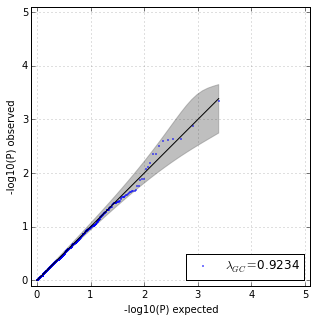

In [7]:
# import the algorithm and reader
from fastlmm.association import epistasis
from pysnptools.snpreader import Bed

# define file names
bed_reader = Bed("../../tests/datasets/synth/all")
pheno_fn = "../../tests/datasets/synth/pheno_10_causals.txt"
cov_fn = "../../tests/datasets/synth/cov.txt"

# partition data into the first 50 SNPs on chr1 and all but chr1
G0 = bed_reader[:,bed_reader.pos[:,0] != 1]
test_snps = bed_reader[:,bed_reader.pos[:,0] == 1][:,0:50]

# run epistasis analysis
results_df = epistasis(test_snps, pheno_fn, G0=G0, covar=cov_fn)

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
print results_df.head(n=10)

# qq plot
from fastlmm.util.stats import plotp
plotp.qqplot(results_df["PValue"].values, xlim=[0,5], ylim=[0,5])

### SNP-set association testing

SNP-set association testing is performed similarly to single-SNP testing.  The output columns are described in the Appendix.  Both LRT and score tests are supported, and the analysis may be run with or without a background GSM to correct for confounding.  Here is an example that uses the LRT and no background GSM--note the inflation in the results.  If you include a background GSM (using `G0`) type I error will be better controlled.  Again, proximal contamination is avoided using LOOC.  

loadPhen is using default missing value of '-9'.
loadPhen is using default missing value of '-9'.
    SetId  LogLikeAlt  LogLikeNull  P-value_adjusted  P-value(50/50)  #SNPs_in_Set  #ExcludedSNPs  chrm pos. range    Alt_h2  Alt_a2
0  set_65 -703.888501  -707.609745          0.002564        0.003185            10              0     1    650-659  0.029725       0
1  set_86 -704.240753  -707.609745          0.003768        0.004719            10              0     1    860-869  0.030321       0
2  set_70 -704.525274  -707.609745          0.005158        0.006501            10              0     1    700-709  0.029790       0
3  set_18 -704.920236  -707.609745          0.008020        0.010190            10              0     1    180-189  0.024803       0
4  set_45 -705.410762  -707.609745          0.014031        0.017991            10              0     1    450-459  0.023440       0
5  set_84 -705.507312  -707.609745          0.015693        0.020154            10              0     1 

C:\Anaconda\lib\site-packages\pandas\io\parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  ParserWarning)


(<matplotlib.figure.Figure at 0x3dbff940>,
 array([  2.30103000e+00,   1.82390874e+00,   1.60205999e+00,
          1.45593196e+00,   1.34678749e+00,   1.25963731e+00,
          1.18708664e+00,   1.12493874e+00,   1.07058107e+00,
          1.02227639e+00,   9.78810701e-01,   9.39302160e-01,
          9.03089987e-01,   8.69666232e-01,   8.38631998e-01,
          8.09668302e-01,   7.82516056e-01,   7.56961951e-01,
          7.32828272e-01,   7.09965389e-01,   6.88246139e-01,
          6.67561540e-01,   6.47817482e-01,   6.28932138e-01,
          6.10833916e-01,   5.93459820e-01,   5.76754126e-01,
          5.60667306e-01,   5.45155140e-01,   5.30177984e-01,
          5.15700161e-01,   5.01689446e-01,   4.88116639e-01,
          4.74955193e-01,   4.62180905e-01,   4.49771647e-01,
          4.37707136e-01,   4.25968732e-01,   4.14539270e-01,
          4.03402904e-01,   3.92544977e-01,   3.81951903e-01,
          3.71611070e-01,   3.61510743e-01,   3.51639989e-01,
          3.41988603e-01,  

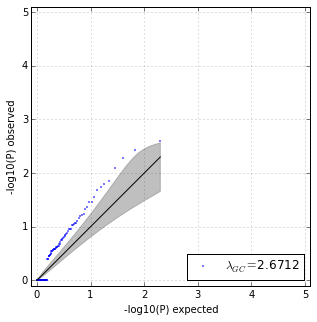

In [8]:
# this will take a few minutes to run

# import the algorithm and reader
from fastlmm.association import snp_set

# define file names
test_snps_fn = "../../tests/datasets/synth/chr1"
pheno_fn = "../../tests/datasets/synth/pheno_10_causals.txt"
cov_fn = "../../tests/datasets/synth/cov.txt"
set_list_fn = "../../tests/datasets/synth/chr1.sets.txt"

# run SNP-set analysis
results_df = snp_set(test_snps_fn, set_list_fn, pheno_fn, covar=cov_fn, test="lrt")

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
print results_df.head(n=10)

# qq plot
from fastlmm.util.stats import plotp
plotp.qqplot(results_df["P-value_adjusted"].values, xlim=[0,5], ylim=[0,5])


The `G1` option available for single-marker testing is not yet supported for set testing.  With the same caveats as previously described, however, you can use a `G0` based on selected SNPs and PC covariates when your data is confounded only by population structure.


### Appendix

Columns in the output are as follows:

`SNP` or `Set`
The SNP or set identifier tested.

`PValue`
The _P_ value computed for the SNP tested.

`NullLogLike`
The log likelihood of the null model.

`AltLogLike`
The log likelihood of the alternative model.

Global statistics, such as sample size and the number of SNPs tested are printed to stdout at the end of the run.

######Single-SNP testing only:

`Chr`
The chromosome identifier for the SNP tested or 0 if unplaced.  Taken from the PLINK file.

`GenDist`
The genetic distance of the SNP on the chromosome.  Taken from the PLINK file.  Any units are allowed, but typically centimorgans or morgans are used.

`ChrPos`
The base-pair position of the SNP on the chromosome (bp units).  Taken from the PLINK file.

`SnpWeight`
The fixed-effect weight of the SNP.

`SnpWeightSE`
The standard error of the SnpWeight.

`Nullh2`
The narrow sense heritability given by h2 $=σ_g^2/(σ_g^2+σ_e^2)$ on the null model.

######SNP-set testing only:

`#SNPs_in_Set`
The number of markers in the set.

`Alt_h2`
The value found in the alt. model, given by $\sigma^2(h2(a2*K_S+(1-a2) * K_C)+(1-h2)*I)$, where $K_C$ is the NxN matrix to correct for confounding, and $K_S$ is the matrix containing SNPs to be tested.	

`Alt_a2`
See Alt_h2.

`Null_h2`
The value found in the null model, given by $\sigma^2(h2*K_C+1-h2)*I)$, where $K_C$ is the $N \times N$ matrix to correct for confounding.
